# Cross-lingual Books Alignment With Transformers and Something OpenVINO™

Pipeline:
1. Get text for alignment
1. Clean text
1. Split text into sentences
1. Get sentence embeddings
1. Calculate sentence similarity
1. Transform similarity into alignment

In [39]:
!pip install -q pysbd transformers[torch] openvino_dev>=2023.0 seaborn
# !pip install gutenbergpy
# !pip install git:...

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Get The Books

First step is to get books that we will be working with. For this notebook we will use english and german versions of Anna Karenina by Leo Tolstoy. The texts can be obtained from [Project Gutenberg site](https://www.gutenberg.org/). Since the copyright laws are complicated and differ from country to country, check if the book is legal to obtain in your country. You can start with Project Gutenberg Permissions, Licensing and other Common Requests [page](https://www.gutenberg.org/policy/permission.html).

First one needs to find a books on a Project Gutenberg [search page](https://www.gutenberg.org/ebooks/) and get the each book id. To get the texts we will pass ids to the `gutenbergpy` library.

In [ ]:
from gutenbergpy.textget import get_text_by_id, strip_headers


def get_book(book_id: int) -> str:
    raw_text = get_text_by_id(book_id)
    cleaned_text = strip_headers(raw_text)
    return cleaned_text.decode().strip()


en_book_id = 1399
de_book_id = 44956

anna_karenina_en = get_book(en_book_id)
anna_karenina_de = get_book(de_book_id)

If you have a timeout or any other issue downloading the books with `gutenbergpy`, the books can be downloaded directly from site:
1. Go to the Project Gutenberg [search page](https://www.gutenberg.org/ebooks/)
1. Search for the book by its id: 1399 for english book, 44956 for german book
1. Go to the book text and choose `Plain Text UTF-8` format
1. Save the book to disk by `Right-Click` -> `Save As...` or press `Ctrl+S`
1. Upload files to the Jupyter with the `Upload Files` button

TODO: add screenshot with `Upload Files` button

In [105]:
def get_book_by_path(path: str) -> str:
    with open(path, "rb") as book:
        raw_text = book.read()
    cleaned_text = strip_headers(raw_text)
    return cleaned_text.decode().strip()


en_book_path = "gutenberg.org_cache_epub_1399_pg1399.txt"
de_book_path = "gutenberg.org_cache_epub_44956_pg44956.txt"

anna_karenina_en = get_book_by_path(en_book_path)
anna_karenina_de = get_book_by_path(de_book_path)

In [106]:
anna_karenina_en[:300]

'[Illustration]\n\n\n\n\n ANNA KARENINA \n\n by Leo Tolstoy \n\n Translated by Constance Garnett \n\nContents\n\n\n PART ONE\n PART TWO\n PART THREE\n PART FOUR\n PART FIVE\n PART SIX\n PART SEVEN\n PART EIGHT\n\n\n\n\nPART ONE\n\nChapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its\nown way.\n\nEveryth'

In [107]:
anna_karenina_de[:1000]

'Online Distributed Proofreading Team at http://www.pgdp.net\n\n\n\n\n\n\n\n\n\n                             Anna Karenina.\n\n\n                        Roman aus dem Russischen\n\n                                  des\n\n                         Grafen Leo N. Tolstoi.\n\n\n\n                  Nach der siebenten Auflage übersetzt\n\n                                  von\n\n                              Hans Moser.\n\n\n                              Erster Band.\n\n\n\n                                Leipzig\n\n                Druck und Verlag von Philipp Reclam jun.\n\n                   *       *       *       *       *\n\n\n\n\n                              Erster Teil.\n\n                               »Die Rache ist mein, ich will vergelten.«\n\n                                   1.\n\n\nAlle glücklichen Familien sind einander ähnlich; jede unglückliche\nFamilie ist auf _ihre_ Weise unglücklich. --\n\nIm Hause der Oblonskiy herrschte allgemeine Verwirrung. Die Dame des\nHauses hatt

## Clean Text

If you open the downloaded books, you'll see that there are some service information before and after actual text. There are different formatting styles and some markup, for example when the author uses prases from different language, this phrases are enclosed with the underscores (probably to italisize them):

>  Yes, Alabin was giving a dinner on glass tables, and the
tables sang, _Il mio tesoro_—not _Il mio tesoro_ though, but something
better, and there were some sort of little decanters on the table, and
they were women, too,” he remembered.

It will be hard to execute next pipeline stages without clining and text normalization. The particular formating might differ from case to case, so this stage requires manual work. For example, the actual content in german version is enclosed in `*       *       *       *       *`, so it is safe to remove everything before the first and after last astrics.

In [108]:
import re


start_pattern_en = r"\nPART ONE"
anna_karenina_en = re.split(start_pattern_en, anna_karenina_en)[1].strip()

end_pattern_en = "*** END OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***"
anna_karenina_en = anna_karenina_en.split(end_pattern_en)[0].strip()

In [109]:
start_pattern_de = "*       *       *       *       *"
anna_karenina_de = anna_karenina_de.split(start_pattern_de, maxsplit=1)[1].strip()
anna_karenina_de = anna_karenina_de.rsplit(start_pattern_de, maxsplit=1)[0].strip()

In [112]:
anna_karenina_de[-1000:]

'les gleichgültig?\n\n»Sprich nicht davon, denke nicht,« versetzte er, ihre Hand in der seinen\nwendend und sich bemühend, ihre Aufmerksamkeit auf sich zu lenken, doch\nsie schaute ihn noch immer nicht an.\n\n»Ach, warum bin ich nicht gestorben; es wäre besser gewesen!« sprach sie\nund ohne daß sie schluchzte, liefen ihr die Thränen über beide Wangen;\ndoch sie bemühte sich, zu lächeln, um ihn nicht zu verstimmen.\n\nDie ehrende und gefährliche Ordre nach Taschkent abzulehnen, war nach\nden früheren Begriffen Wronskiys schmachvoll und unmöglich gewesen.\nJetzt aber schlug er dieselbe, ohne sich eine Minute zu besinnen, aus\nund ging, die Mißbilligung seiner Handlungsweise seitens seiner\nVorgesetzten bemerkend, auf Urlaub.\n\nNach Verlauf eines Monats war Aleksey Aleksandrowitsch allein mit seinem\nSöhnchen in seinem Hause. Anna und Wronskiy waren in das Ausland\ngereist, ohne die Ehescheidung erlangt zu haben, und hatten sich\ndefinitiv von ihm losgesagt.\n\n\n                        

For this notebook we will get just the first chapter.

In [5]:
chapter_pattern_en = r"Chapter \d?\d"
chapter_1_en = re.split(chapter_pattern_en, anna_karenina_en)[1].strip()

In [6]:
chapter_pattern_de = r"\d?\d.\n\n"
chapter_1_de = re.split(chapter_pattern_de, anna_karenina_de)[1].strip()

In [7]:
def remove_single_newline(text: str) -> str:
    return re.sub(r"\n(?!\n)", " ", text)

chapter_1_en = remove_single_newline(chapter_1_en)
chapter_1_de = remove_single_newline(chapter_1_de)

In [8]:
def unify_quotes(text: str) -> str:
    return re.sub(r"['\"»«“”]", '"', text)


chapter_1_en = unify_quotes(chapter_1_en)
chapter_1_de = unify_quotes(chapter_1_de)

In [9]:
def remove_markup(text:str) -> str:
    text = text.replace(">=", "").replace("=<", "")
    return re.sub(r"_\w|\w_", "", text)


chapter_1_en = remove_markup(chapter_1_en)
chapter_1_de = remove_markup(chapter_1_de)

Gather clean functions into a single pipeline:

In [93]:
text_cleaning_pipeline = [
    remove_single_newline,
    unify_quotes,
    remove_markup,
]


def clean_text(text):
    for clean_func in text_cleaning_pipeline:
        text = clean_func(text)
    return text

## Split Text

In [10]:
import pysbd


splitter_en = pysbd.Segmenter(language="en", clean=True)
sentences_en = splitter_en.segment(chapter_1_en)

In [11]:
splitter_de = pysbd.Segmenter(language="de", clean=True)
sentences_de = splitter_de.segment(chapter_1_de)

In [12]:
len(sentences_en), len(sentences_de)

(32, 34)

## Get Text Embeddings

In [13]:
from optimum.intel import OVModelForFeatureExtraction
from transformers import AutoTokenizer
from tqdm.auto import tqdm
import numpy as np


model_id = "rasa/LaBSE"
model = OVModelForFeatureExtraction.from_pretrained(model_id, export=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

2023-06-15 13:09:22.625086: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-15 13:09:22.628390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-15 13:09:22.628401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


Framework not specified. Using pt to export to ONNX.
Using framework PyTorch: 1.13.1+cpu
Overriding 1 configuration item(s)
	- use_cache -> False
Compiling the model...


In [14]:
def get_embeddings(sentences):
    embeddings = [
        model(**tokenizer(sent, return_tensors="np")).last_hidden_state[0, 0]
        for sent in tqdm(sentences)
    ]
    return np.vstack(embeddings)


embeddings_en = get_embeddings(sentences_en)
embeddings_de = get_embeddings(sentences_de)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

## Calculate Sentence Similarity

Text(102.37222222222219, 0.5, 'English')

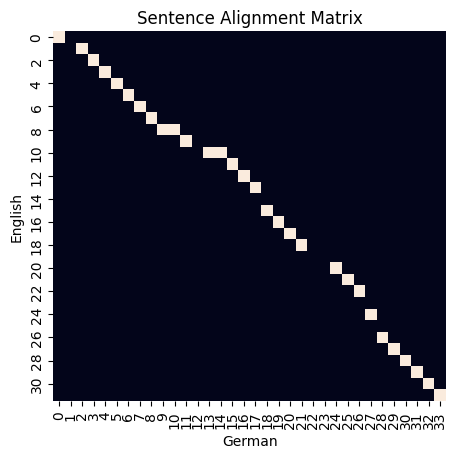

In [86]:
import seaborn as sns


def softmax_stable(x):
    x = x - np.max(x)
    exp = np.exp(x)
    return exp / exp.sum()


similarity = embeddings_en @ embeddings_de.T
softmax_en_to_de = np.apply_along_axis(softmax_stable, -1, similarity)
softmax_de_to_en = np.apply_along_axis(softmax_stable, -2, similarity)

threshold = 1e-20
softmax_inter = (softmax_en_to_de > threshold) * (softmax_de_to_en > threshold)

plot = sns.heatmap(softmax_inter, cbar=False, square=True)
plot.set_title("Sentence Alignment Matrix")
plot.set_xlabel("German")
plot.set_ylabel("English")

## Transform Similarity To Alignment

In [40]:
aligned = {idx: [] for idx, sent in enumerate(sentences_en)}

for en_idx, de_idx in zip(*np.nonzero(softmax_inter)):
    aligned[en_idx].append(de_idx)

In [87]:
from IPython.display import display, HTML
from itertools import zip_longest

def create_interactive_table(list1, list2, mapping):

    def inverse_mapping(mapping):
        inverse_map = {idx: [] for idx in range(len(list2))}

        for key, values in mapping.items():
            for value in values:
                inverse_map[value].append(key)

        return inverse_map
    
    
    inversed_mapping = inverse_mapping(mapping)
    
    table_html = '<table id="mappings-table"><tr><th>Sentences EN</th><th>Sentences DE</th></tr>'

    for i, (first, second) in enumerate(zip_longest(list1, list2)):
        table_html += "<tr>"
        if i < len(list1):
            table_html += f'<td id="list1-{i}">{first}</td>'
        else:
            table_html += "<td></td>"
        if i < len(list2):
            table_html += f'<td id="list2-{i}">{second}</td>'
        else:
            table_html += "<td></td>"
        table_html += "</tr>"

    table_html += "</table>"

    hover_script = """
    <script type="module">
      const highlightColor = '#0054AE';
      const textColor = 'white'
      const mappings = {
        'list1': """ + str(mapping) + """,
        'list2': """ + str(inversed_mapping) + """
      };

      const table = document.getElementById('mappings-table');
      let highlightedIds = [];

      table.addEventListener('mouseover', ({ target }) => {
        if (target.tagName !== 'TD' || !target.id) {
          return;
        }

        const [listName, listId] = target.id.split('-');
        const mappedIds = mappings[listName]?.[listId]?.map((id) => `${listName === 'list1' ? 'list2' : 'list1'}-${id}`) || [];
        const idsToHighlight = [target.id, ...mappedIds];

        setBackgroud(idsToHighlight, highlightColor, textColor);
        highlightedIds = idsToHighlight;
      });

      table.addEventListener('mouseout', () => setBackgroud(highlightedIds, ''));

      function setBackgroud(ids, color, text_color="unset") {
        ids.forEach((id) => {
            document.getElementById(id).style.backgroundColor = color;
            document.getElementById(id).style.color = text_color
        });
      }
    </script>
    """
    return table_html + hover_script

In [88]:
html_code = create_interactive_table(sentences_en, sentences_de, aligned)
display(HTML(html_code))

Sentences EN,Sentences DE
Happy families are all alike; every unhappy family is unhappy in its own way.,Alle glücklichen Familien sind einander ähnlich; jede unglückliche Familie ist auf hr Weise unglücklich.
Everything was in confusion in the Oblonskys’ house.,--
"The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him.",Im Hause der Oblonskiy herrschte allgemeine Verwirrung.
"This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were painfully conscious of it.","Die Dame des Hauses hatte in Erfahrung gebracht, daß ihr Gatte mit der im Hause gewesenen französischen Gouvernante ein Verhältnis unterhalten, und ihm erklärt, sie könne fürderhin nicht mehr mit ihm unter einem Dache bleiben."
"Every person in the house felt that there was no sense in their living together, and that the stray people brought together by chance in any inn had more in common with one another than they, the members of the family and household of the Oblonskys.","Diese Situation währte bereits seit drei Tagen und sie wurde nicht allein von den beiden Ehegatten selbst, nein auch von allen Familienmitgliedern und dem Personal aufs Peinlichste empfunden."
"The wife did not leave her own room, the husband had not been at home for three days.","Sie alle fühlten, daß in ihrem Zusammenleben kein höherer Gedanke mehr liege, daß die Leute, welche auf jeder Poststation sich zufällig träfen, noch enger zu einander gehörten, als sie, die Glieder der Familie selbst, und das im Hause geborene und aufgewachsene Gesinde der Oblonskiy."
"The children ran wild all over the house; the English governess quarreled with the housekeeper, and wrote to a friend asking her to look out for a new situation for her; the man-cook had walked off the day before just at dinner time; the kitchen-maid, and the coachman had given warning.","Die Herrin des Hauses verließ ihre Gemächer nicht, der Gebieter war schon seit drei Tagen abwesend."
"Three days after the quarrel, Prince Stepan Arkadyevitch Oblonsky—Stiva, as he was called in the fashionable world—woke up at his usual hour, that is, at eight o’clock in the morning, not in his wife’s bedroom, but on the leather-covered sofa in his study.","Die Kinder liefen wie verwaist im ganzen Hause umher, die Engländerin schalt auf die Wirtschafterin und schrieb an eine Freundin, diese möchte ihr eine neue Stellung verschaffen, der Koch hatte bereits seit gestern um die Mittagszeit das Haus verlassen und die Köchin, sowie der Kutscher hatten ihre Rechnungen eingereicht."
"He turned over his stout, well-cared-for person on the springy sofa, as though he would sink into a long sleep again; he vigorously embraced the pillow on the other side and buried his face in it; but all at once he jumped up, sat up on the sofa, and opened his eyes.","Am dritten Tage nach der Scene erwachte der Fürst Stefan Arkadjewitsch Oblonskiy -- Stiwa hieß er in der Welt -- um die gewöhnliche Stunde, das heißt um acht Uhr morgens, aber nicht im Schlafzimmer seiner Gattin, sondern in seinem Kabinett auf dem Saffiandiwan."
"""Yes, yes, how was it now?"" he thought, going over his dream.","Er wandte seinen vollen verweichlichten Leib auf den Sprungfedern des Diwans, als wünsche er noch weiter zu schlafen, während er von der andern Seite innig ein Kissen umfaßte und an die Wange drückte."


We can save the model to disk for later use.

In [89]:
model.save_pretrained("ov_model")

## Speed Up Embedding Computation

In [92]:
from openvino.runtime import Core, AsyncInferQueue, InferRequest


core = Core()
model = core.read_model("ov_model/openvino_model.xml")
compiled_throughput_hint = core.compile_model(
    model,
    device_name="CPU",
    config={"PERFORMANCE_HINT":"THROUGHPUT"},
)

In [113]:
all_sentences_en = splitter_en.segment(clean_text(anna_karenina_en))
len(all_sentences_en)

15778

In [115]:
def get_embeddings(sentences):
    embeddings = [
        compiled_throughput_hint(dict(tokenizer(sent, return_tensors="np")))["last_hidden_state"][0, 0]
        for sent in tqdm(sentences)
    ]
    return np.vstack(embeddings)

In [116]:
%%timeit
get_embeddings(all_sentences_en[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

2.62 s ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def get_embeddings_async(sentences):
    def callback(infer_request, user_data):
        embeddings, idx, pbar = user_data
        embedding = infer_request.get_output_tensor().data[0, 0]
        embeddings[idx] = embedding
        pbar.update()


    infer_queue = AsyncInferQueue(model_throughput_hint)
    infer_queue.set_callback(callback)

    embedding_dim = model_throughput_hint.output().get_partial_shape().get_dimension(2).get_length()
    embeddings = np.zeros((len(sentences), embedding_dim))
    with tqdm(total=len(sentences)) as pbar:
        for idx, sent in enumerate(sentences):
            tokenized = dict(tokenizer(sent, return_tensors="np"))

            infer_queue.start_async(
                tokenized,
                [embeddings, idx, pbar]
            )

        infer_queue.wait_all()

    return embeddings